In [1]:
# standard python utilities
import os
from os.path import join, dirname, basename
import glob
import sys
import time
import pandas as pd
import numpy as np

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir
dis_dir = join(gwfm_dir, 'DIS_data')
uzf_dir = join(gwfm_dir,'UZF_data')

In [3]:
# New model domain 52.9 deg
m_domain = gpd.read_file(join(dis_dir,'NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp'))

# Load model grid as geopandas object
grid_p = gpd.read_file(join(dis_dir,'grid/grid.shp'))



In [4]:
nrow = grid_p.row.max()
ncol = grid_p.column.max()

In [6]:
uzf_dir = gwfm_dir+'/UZF_data'
soil_path = uzf_dir+'/wss_gsmsoil_CA'
soil_out_dir = join(uzf_dir, 'final_soil_arrays')

# Read in the soil map spatial data
soil_gpd = gpd.read_file(soil_path+'/spatial/gsmsoilmu_a_ca.shp')
soil_gpd = soil_gpd.to_crs(m_domain.crs)
# soil_gpd.plot()

In [7]:
# Intersect state soil map with model domain
gpd_mb = gpd.overlay(soil_gpd, m_domain, how = 'intersection')
# Prepare the column name for joining spatial data with the reference data
gpd_mb = gpd_mb.rename(columns={'MUKEY':'mukey'})
# prepare to match with tabular data
gpd_mb.mukey = gpd_mb.mukey.values.astype('int64')

# gpd_mb.plot(column = 'MUKEY')

|ID  |Name | Units|
|:---------:|:---------|:-----:|
|Ksat|Saturated hydraulic conductivity| micrometers/sec|
|Porosity| Porosity| percent|
|SoilDepth| Soil Depth| cm|
|w15bar| wilting point| percent|
|w3rdbar| field capacity|percent|
|w10thbar| Alternative field capacity|percent|
|AWC| available water content| cmc/cm|
|PSDI| pore size distribution index ($\lambda$)|percent|

In [8]:
soil_files = glob.glob(soil_path+'/soildb_US_2003*.txt')
soil = pd.read_csv(soil_files[0], sep=',', header = 0)
for f in soil_files[1:]:
    df = pd.read_csv(f,sep=',', header = 0)
    soil = soil.merge(df, on = 'mukey', how = 'inner')
# pull out representative values
soil_rep = soil.copy()[np.append(['mukey', 'SoilDepth', 'Texture','HydGroup', 'Ksat_Low'],
                          soil.columns[soil.columns.str.contains('Rep')])]
soil_rep.columns = soil_rep.columns.str.replace('_Rep','')
# Calculate epsilon using the pore size distribution index equation from Brooks and Corey 1960
soil_rep['EPS'] = (2 + 3*soil_rep.PSDI)/soil_rep.PSDI

# Convert Ksat from micrometers/sec to m/d
soil_rep.Ksat *= (86400*(1E-6))
soil_rep.Ksat_Low *= (86400*(1E-6))

# convert soil depth from cm to meters
soil_rep.SoilDepth *= (1E-2)

# join spatial with tabular
gpd_soil = gpd_mb.merge(soil_rep, on = 'mukey')

# save soil map units with parameters to a shapefile before joining to the grid
gpd_soil.to_file(join(uzf_dir, 'clean_soil_data', 'cleaned_spatial_soil.shp'))

In [9]:
# Samples the points every 10 meters to match with the 100 meter grid
grid_uzf = gpd.sjoin(gpd_soil, grid_p,   how = "inner", predicate= "intersects").drop(columns=['index_right'])
# grid_uzf = gpd.overlay(grid_p, gpd_mb,  how = 'intersection')



In [10]:
# Dissolves the points every 10 meters to the 100 meter spacing
# grid_uzf = grid_uzf.dissolve(by = 'node')
# length of 70,073 before dissolve, 66,000 after dissolve

In [11]:
# grid_uzf.to_file(uzf_dir+'/final_grid_uzf/griduzf.shp')
grid_uzf = gpd.read_file(uzf_dir+'/final_grid_uzf/griduzf.shp')

In [12]:
def fill_uzf(uzfvalues, grid_uzf):
#     temp = np.zeros((nrow,ncol))
    temp = np.full((nrow,ncol),np.nan, dtype = uzfvalues.dtype)
    temp[grid_uzf.row.values-1,grid_uzf.column.values-1] = uzfvalues
    return(temp)



In [13]:
nrow = grid_p.row.max()
ncol = grid_p.column.max()

soilKs_array = fill_uzf(grid_uzf.Ksat, grid_uzf)
soiln_array = fill_uzf(grid_uzf.Porosity, grid_uzf)
soileps_array = fill_uzf(grid_uzf.EPS, grid_uzf)

# np.savetxt(soil_out_dir+'/final_soilKs.tsv', soilKs_array, delimiter = '\t')
# np.savetxt(soil_out_dir+'/final_soiln.tsv', soiln_array, delimiter = '\t')
# np.savetxt(soil_out_dir+'/final_soileps.tsv', soileps_array, delimiter = '\t')

# soilKs_array = np.loadtxt(uzf_dir+'/final_soilKs.tsv', delimiter = '\t')
# soiln_array = np.loadtxt(uzf_dir+'/final_soiln.tsv', delimiter = '\t')
# soileps_array = np.loadtxt(uzf_dir+'/final_soileps.tsv', delimiter = '\t')


In [14]:
temp = np.zeros((nrow,ncol))
temp[grid_uzf.row.values-1,grid_uzf.column.values-1] = grid_uzf.Ksat.values
temp.shape


(100, 230)

# Landuse relevant to runoff

In [15]:
# load data for slope
zs_df = gpd.read_file(join(dis_dir, 'grid_zonal_stats','slope_percentage_statistics.shp'))


In [83]:
lu_yr = gpd.read_file(join(uzf_dir, 'county_landuse','domain_ag_lu_2018.shp'))
lu_native_yr = gpd.read_file(join(uzf_dir, 'county_landuse','domain_native_lu_2018.shp'))
lu_urban_yr = gpd.read_file(join(uzf_dir, 'county_landuse','domain_urban_lu_2018.shp'))

In [17]:
# join land use withg eneric classes to match cuve number data
lu_gen = pd.concat((lu_yr.assign(lu='Cultivated land'), lu_native_yr.assign(lu='Pasture'), 
                    lu_urban_yr.assign(lu='Residential')))
lu_gen = lu_gen[['MULTIUSE', 'PCNT','name','geometry','lu']]


In [18]:
# overlay crops geometry so cell area can be taken into account
# join soil data to slope grid
C_gpd = gpd.overlay(gpd_soil, zs_df)
# join generic land use
C_gpd = gpd.overlay(lu_gen[['name','lu','geometry']], C_gpd)


<Axes: >

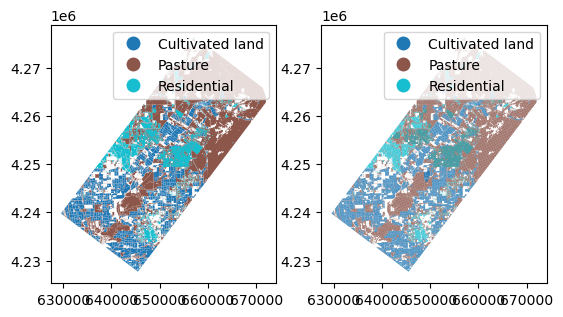

In [19]:
fig,ax = plt.subplots(1,2)
C_gpd.plot('lu',legend=True, ax=ax[1])
lu_gen.plot('lu', legend=True, ax=ax[0])

In [84]:
# join ag land use to grid for creating array of irr efficiencies
lu_ag_grid = gpd.overlay(lu_yr, grid_p)

In [85]:
# initially just use a static array, this can be made dynamic for years later
irr_eff = np.zeros((nrow,ncol))
irr_eff[lu_ag_grid.row-1, lu_ag_grid.column-1] = lu_ag_grid.Avg_eff/100

In [86]:
lu_ag_grid[lu_ag_grid.Avg_eff.isna()]

,WATERSOURC,MULTIUSE,crop_num,SURVEYAREA,SURVEYYEAR,geom_id,CLASS,CROPTYP,IRR_TYP_PA,IRR_TYP_PB,...,High_eff,Comment,Avg_eff,county,name_plot,yr_diff,node,row,column,geometry


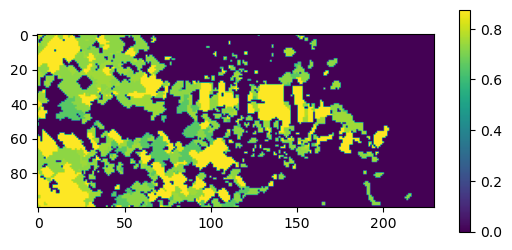

In [90]:
plt.imshow(irr_eff)
plt.colorbar(shrink=0.6)
np.savetxt(join(soil_out_dir, 'static_irrigation_efficiency.csv'), irr_eff, delimiter=',')

# Estimate runoff coefficients
Curve number is generally based on land use permeability, and additionally soil permeability and slope.:
- Land use for CN is fairly basic, so here it will be broken up into residential, cultivated, pasture for simplicity
- Soil permeability comes from Hydrologic Soil group (A, B, C, D) (high to low infiltration
- Generally slope is grouped in none, moderate or steep (0-2, 2-6, 6+)

"The curve number CN values range from approximately 30 for permeable soils with high infiltration rates to 100 for water bodies and soils with low infiltration rates." HEC - USACE
https://www.hec.usace.army.mil/confluence/hmsdocs/hmstrm/cn-tables

In [10]:
# load curve number data and clean up
C = pd.read_excel(join(gwfm_dir,'UZF_data','runoff_coefficients.xlsx'), comment='#', header=[0,1])
C_long = C.melt(id_vars = [(0,'Cover type'),(0,'Impervious')])
C_long[['slope_min', 'slope_max']] = C_long.variable_1.str.split(r'\W',expand=True)
# clean up columns
C_long = C_long.rename(columns = {'variable_0':'HydGroup','value':'C'})
C_long['lu'] = C_long[(0,'Cover type')]
C_long['impervious'] = C_long[(0,'Impervious')]
# columns for joining
C_long = C_long[['HydGroup','slope_min','slope_max','lu','impervious', 'C']]

In [106]:
# join if Hyd Group matches, land use is in cover type,
# then filter by checking slope and impervious area

# join spatial data to ID data for Curve Numbers
C_out = C_gpd.join(C_long.set_index(['HydGroup','lu']), on=['HydGroup','lu'], how='inner')

# filter groups to those within the slope ranges
C_out = C_out.loc[(C_out['mean'] > C_out.slope_min.astype(float))&(C_out['mean'] < C_out.slope_max.astype(float))]

In [107]:
# no quick way to estimate impervious surface and residential area is not as important as foothills
# so for now leave it to average the CNs

In [108]:
C_mean = C_out.dissolve(['node','row','column'], aggfunc='mean').reset_index()

C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [126]:
c_arr = np.zeros((nrow,ncol))
c_arr[C_mean.row-1, C_mean.column-1] = C_mean.C
np.savetxt(join(soil_out_dir, 'final_soil_runoff_coeff.csv'), cn_arr, delimiter=',')

<Axes: >

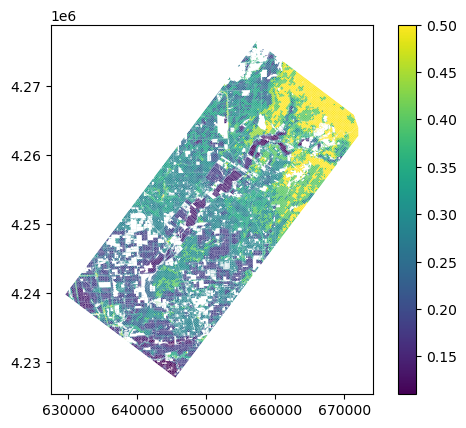

In [110]:
C_mean.plot('C', legend=True)

# Curve Number

In [8]:
# load curve number data and clean up
CN = pd.read_excel(join(gwfm_dir,'UZF_data','curve_numbers.xlsx'), comment='#')
CN = CN.rename(columns={'Cover type':'lu', 'Impervious':'impervious', 'Hydrologic Condition':'HydCond'})

CN_long = CN.melt(id_vars = ['lu','impervious','HydCond'], var_name='HydGroup', value_name='CN')
# clean up columns
# CN_long['lu'] = CN_long['Cover type']
# CN_long['impervious'] = CN_long['Impervious']
# columns for joining
CN_long = CN_long[['HydGroup','lu','impervious', 'HydCond', 'CN']]

In [18]:
# join spatial data to ID data for Curve Numbers
CN_out = C_gpd.join(CN_long.set_index(['HydGroup','lu']), on=['HydGroup','lu'], how='inner')

# for pasture there is an option of fair or poor hydrologic condition
# poor condition should be associated with slopes greater than 3%, less than 50% cover in hills
CN_pasture = CN_out[CN_out.lu=='Pasture']
hills_pasture = CN_pasture[(CN_pasture['mean']>=3)&(CN_pasture.HydCond=='Poor')]
flat_pasture = CN_pasture[(CN_pasture['mean']<3)&(CN_pasture.HydCond=='Fair')]
CN_pasture = pd.concat((hills_pasture, flat_pasture))
# add pasture back to out file
CN_out = CN_out[CN_out.lu!='Pasture']
CN_out = pd.concat((CN_out, CN_pasture))

Adding the adjustment of slope between fair and poor increased CN in the foothills so it was on the same scale as the lower lying areas generally. Doesn't appear to be a huge change.

In [55]:
CN_mean = CN_out.dissolve(['node','row','column'], aggfunc='mean').reset_index()

C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [58]:
cn_arr = np.zeros((nrow,ncol))
cn_arr[CN_mean.row-1, CN_mean.column-1] = CN_mean.CN
np.savetxt(join(soil_out_dir, 'final_soil_CN.csv'), cn_arr, delimiter=',')

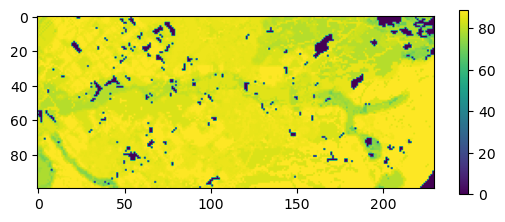

In [57]:
plt.imshow(cn_arr)
plt.colorbar(shrink=0.5)